# Анализ результатов сканирования коэффициентов PID

## Структура эксперимента

1. **Первый warmup** (1000 шагов): Kp=3.5, Ki=11.0, Kd=0.02, u_min=2000, u_max=2500
2. **Первый эксперимент**: Сканирование Kp (13.5 → 1.0, шаг -0.5) и Kd (0.0 → 0.01, 50 точек), Ki=11.0, 200 шагов на комбинацию
3. **Второй warmup** (1000 шагов): Kp=3.5, Ki=11.0, Kd=0.02, u_min=2000, u_max=2500
4. **Второй эксперимент**: Сканирование только Kp (1.5 → 13.5, 100 точек), Ki=0.0, Kd=0.0, 200 шагов на точку

## Формат данных

Каждая строка в логе имеет формат:
- **Отправка**: `step={step} type={type} send kp={kp:.4f} ki={ki:.4f} kd={kd:.4f} u_min={u_min:.4f} u_max={u_max:.4f}`
- **Получение**: `step={step} type={type} recv process_variable={pv:.4f} control_output={co:.4f}`


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from typing import List
from dataclasses import dataclass
from enum import Enum

## Загрузка и парсинг данных


In [26]:
@dataclass
class InteractionData:
    step: int
    interaction_type: str
    kp: float
    ki: float
    kd: float
    u_min: float
    u_max: float
    process_variable: float
    control_output: float
    timestamp: str = ""

class InteractionType(Enum):
    FIRST_WARMUP = "first_warmup"
    FIRST_EXP = "first_exp"
    SECOND_WARMUP = "second_warmup"
    SECOND_EXP = "second_exp"

def parse_log_line(line: str) -> InteractionData:
    """Парсит строку лога и возвращает структурированные данные"""
    # Паттерны для парсинга
    send_pattern = r'step=(\d+) type=(\w+) send kp=([\d.]+) ki=([\d.]+) kd=([\d.]+) u_min=([\d.]+) u_max=([\d.]+)'
    recv_pattern = r'step=(\d+) type=(\w+) recv process_variable=([\d.]+) control_output=([\d.]+)'
    
    # Проверяем, является ли строка отправкой или получением
    send_match = re.search(send_pattern, line)
    recv_match = re.search(recv_pattern, line)
    
    if send_match:
        step, interaction_type, kp, ki, kd, u_min, u_max = send_match.groups()
        return InteractionData(
            step=int(step),
            interaction_type=interaction_type,
            kp=float(kp),
            ki=float(ki),
            kd=float(kd),
            u_min=float(u_min),
            u_max=float(u_max),
            process_variable=0.0,  # Будет заполнено при получении
            control_output=0.0
        )
    elif recv_match:
        step, interaction_type, process_variable, control_output = recv_match.groups()
        return InteractionData(
            step=int(step),
            interaction_type=interaction_type,
            kp=0.0,  # Будет заполнено из предыдущей отправки
            ki=0.0,
            kd=0.0,
            u_min=0.0,
            u_max=0.0,
            process_variable=float(process_variable),
            control_output=float(control_output)
        )
    
    return None

def load_experiment_data(log_file_path: str) -> List[InteractionData]:
    """Загружает и парсит данные эксперимента из файла лога"""
    data = []
    send_data = {}  # Временное хранилище для данных отправки
    
    with open(log_file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
                
            parsed = parse_log_line(line)
            if parsed is None:
                continue
            
            if 'send' in line:
                # Сохраняем данные отправки
                send_data[parsed.step] = parsed
            elif 'recv' in line:
                # Объединяем с данными отправки
                if parsed.step in send_data:
                    send_info = send_data[parsed.step]
                    complete_data = InteractionData(
                        step=parsed.step,
                        interaction_type=parsed.interaction_type,
                        kp=send_info.kp,
                        ki=send_info.ki,
                        kd=send_info.kd,
                        u_min=send_info.u_min,
                        u_max=send_info.u_max,
                        process_variable=parsed.process_variable,
                        control_output=parsed.control_output
                    )
                    data.append(complete_data)
                    del send_data[parsed.step]  
    
    return data


## Загрузка данных эксперимента


In [27]:
log_file_path = "../experiments/coefficient_scan/2025-10-24_20-35-10/logs/log.log"

print(f"Загрузка данных из: {log_file_path}")
experiment_data = load_experiment_data(log_file_path)
print(f"Загружено {len(experiment_data)} записей")

df = pd.DataFrame([
    {
        'step': d.step,
        'interaction_type': d.interaction_type,
        'kp': d.kp,
        'ki': d.ki,
        'kd': d.kd,
        'u_min': d.u_min,
        'u_max': d.u_max,
        'process_variable': d.process_variable,
        'control_output': d.control_output
    }
    for d in experiment_data
])

print(f"\nПервые 5 записей:")
print(df.head())

print(f"\nСтатистика по типам взаимодействий:")
print(df['interaction_type'].value_counts())

SETPOINT = 1200

df['error'] = df['process_variable'] - SETPOINT
df['error_abs'] = abs(df['error'])


Загрузка данных из: ../experiments/coefficient_scan/2025-10-24_20-35-10/logs/log.log
Загружено 272000 записей

Первые 5 записей:
   step interaction_type   kp    ki    kd   u_min   u_max  process_variable  \
0     0     first_warmup  3.5  11.0  0.02  2000.0  2500.0            1070.0   
1     1     first_warmup  3.5  11.0  0.02  2000.0  2500.0            1070.0   
2     2     first_warmup  3.5  11.0  0.02  2000.0  2500.0            1120.0   
3     3     first_warmup  3.5  11.0  0.02  2000.0  2500.0             970.0   
4     4     first_warmup  3.5  11.0  0.02  2000.0  2500.0            1650.0   

   control_output  
0             0.0  
1          2045.0  
2          2045.0  
3          2008.0  
4          2000.0  

Статистика по типам взаимодействий:
interaction_type
first_exp        250000
second_exp        20000
first_warmup       1000
second_warmup      1000
Name: count, dtype: int64


## Разделение данных по фазам эксперимента


In [28]:
first_warmup = df[df['interaction_type'] == 'first_warmup'].copy()
first_exp = df[df['interaction_type'] == 'first_exp'].copy()
second_warmup = df[df['interaction_type'] == 'second_warmup'].copy()
second_exp = df[df['interaction_type'] == 'second_exp'].copy()

print(f"Данные по фазам:")
print(f"Первый warmup: {len(first_warmup)} записей")
print(f"Первый эксперимент: {len(first_exp)} записей")
print(f"Второй warmup: {len(second_warmup)} записей")
print(f"Второй эксперимент: {len(second_exp)} записей")

Данные по фазам:
Первый warmup: 1000 записей
Первый эксперимент: 250000 записей
Второй warmup: 1000 записей
Второй эксперимент: 20000 записей


## Визуализация временных рядов


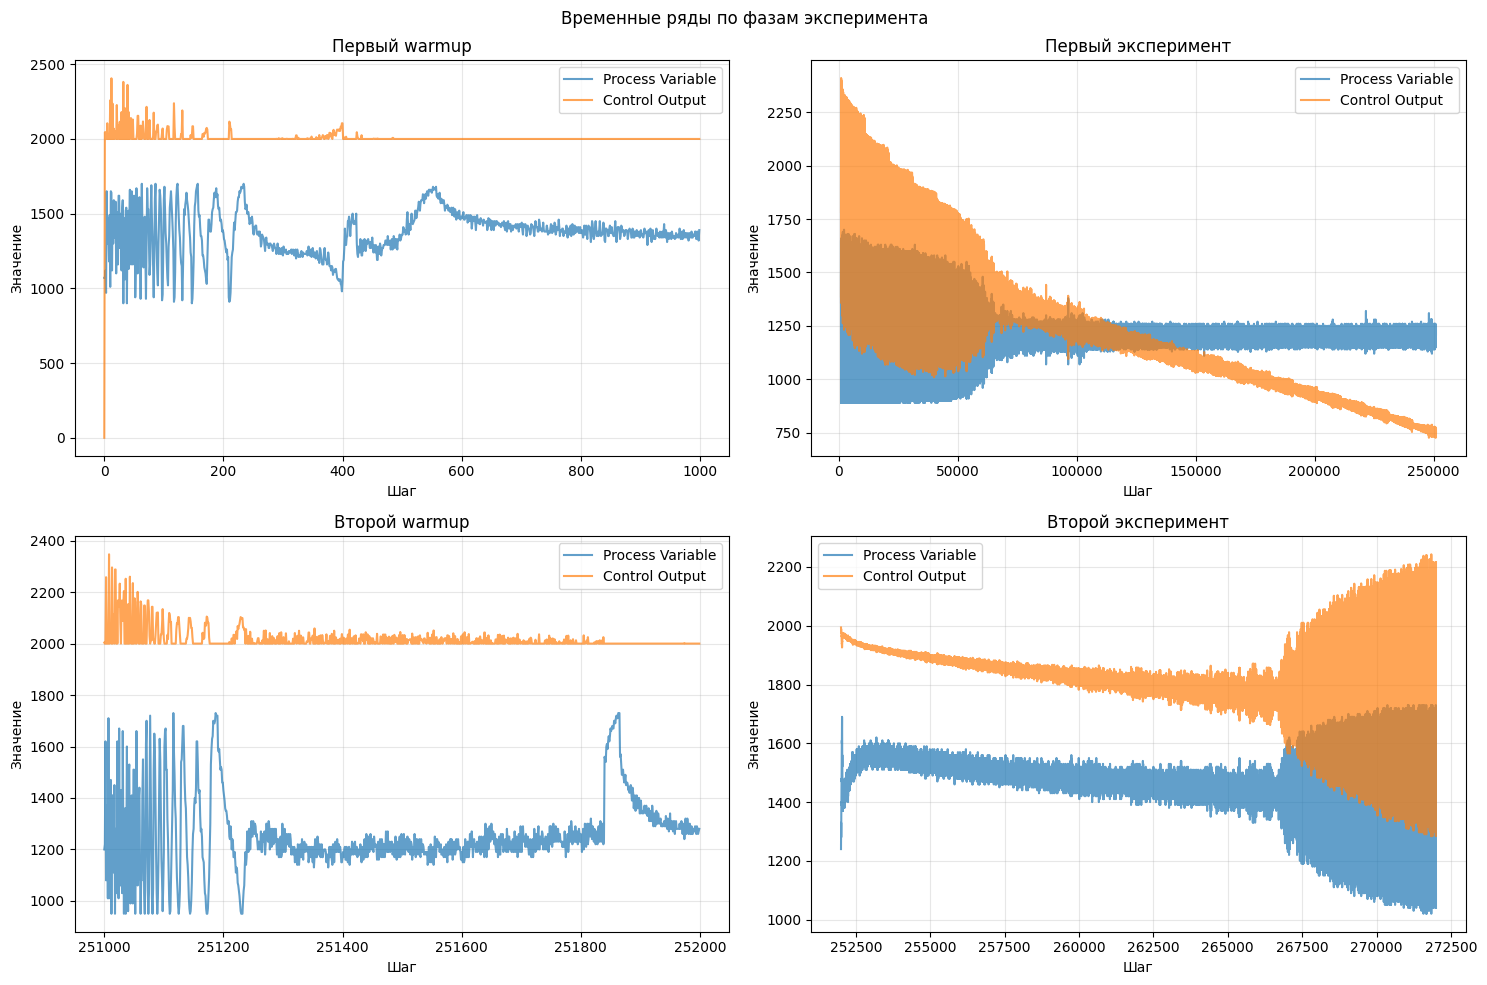

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Временные ряды по фазам эксперимента')

axes[0, 0].plot(first_warmup['step'], first_warmup['process_variable'], label='Process Variable', alpha=0.7)
axes[0, 0].plot(first_warmup['step'], first_warmup['control_output'], label='Control Output', alpha=0.7)
axes[0, 0].set_title('Первый warmup')
axes[0, 0].set_xlabel('Шаг')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(first_exp['step'], first_exp['process_variable'], label='Process Variable', alpha=0.7)
axes[0, 1].plot(first_exp['step'], first_exp['control_output'], label='Control Output', alpha=0.7)
axes[0, 1].set_title('Первый эксперимент')
axes[0, 1].set_xlabel('Шаг')
axes[0, 1].set_ylabel('Значение')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(second_warmup['step'], second_warmup['process_variable'], label='Process Variable', alpha=0.7)
axes[1, 0].plot(second_warmup['step'], second_warmup['control_output'], label='Control Output', alpha=0.7)
axes[1, 0].set_title('Второй warmup')
axes[1, 0].set_xlabel('Шаг')
axes[1, 0].set_ylabel('Значение')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(second_exp['step'], second_exp['process_variable'], label='Process Variable', alpha=0.7)
axes[1, 1].plot(second_exp['step'], second_exp['control_output'], label='Control Output', alpha=0.7)
axes[1, 1].set_title('Второй эксперимент')
axes[1, 1].set_xlabel('Шаг')
axes[1, 1].set_ylabel('Значение')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

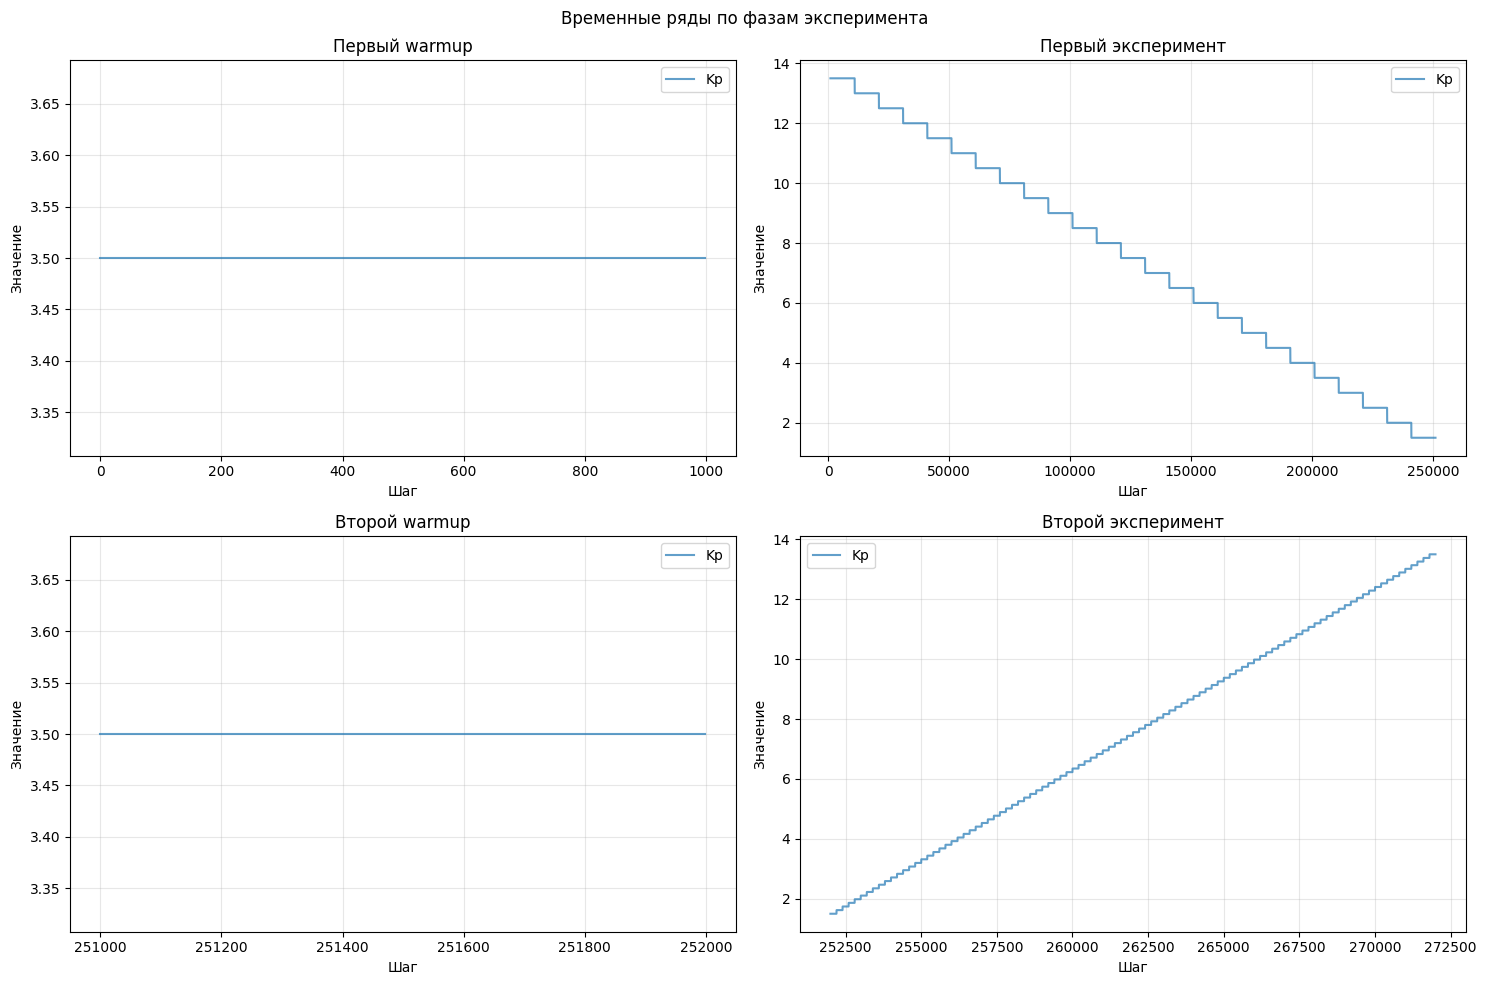

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Временные ряды по фазам эксперимента')

axes[0, 0].plot(first_warmup['step'], first_warmup['kp'], label='Kp', alpha=0.7)
axes[0, 0].set_title('Первый warmup')
axes[0, 0].set_xlabel('Шаг')
axes[0, 0].set_ylabel('Значение')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(first_exp['step'], first_exp['kp'], label='Kp', alpha=0.7)
axes[0, 1].set_title('Первый эксперимент')
axes[0, 1].set_xlabel('Шаг')
axes[0, 1].set_ylabel('Значение')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(second_warmup['step'], second_warmup['kp'], label='Kp', alpha=0.7)
axes[1, 0].set_title('Второй warmup')
axes[1, 0].set_xlabel('Шаг')
axes[1, 0].set_ylabel('Значение')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(second_exp['step'], second_exp['kp'], label='Kp', alpha=0.7)
axes[1, 1].set_title('Второй эксперимент')
axes[1, 1].set_xlabel('Шаг')
axes[1, 1].set_ylabel('Значение')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Анализ первого эксперимента (сканирование Kp и Kd)


C:\Users\artem\AppData\Local\Temp\ipykernel_6088\2018700271.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_100_steps = first_exp.groupby(['kp', 'kd']).apply(get_last_100_steps).reset_index(drop=True)


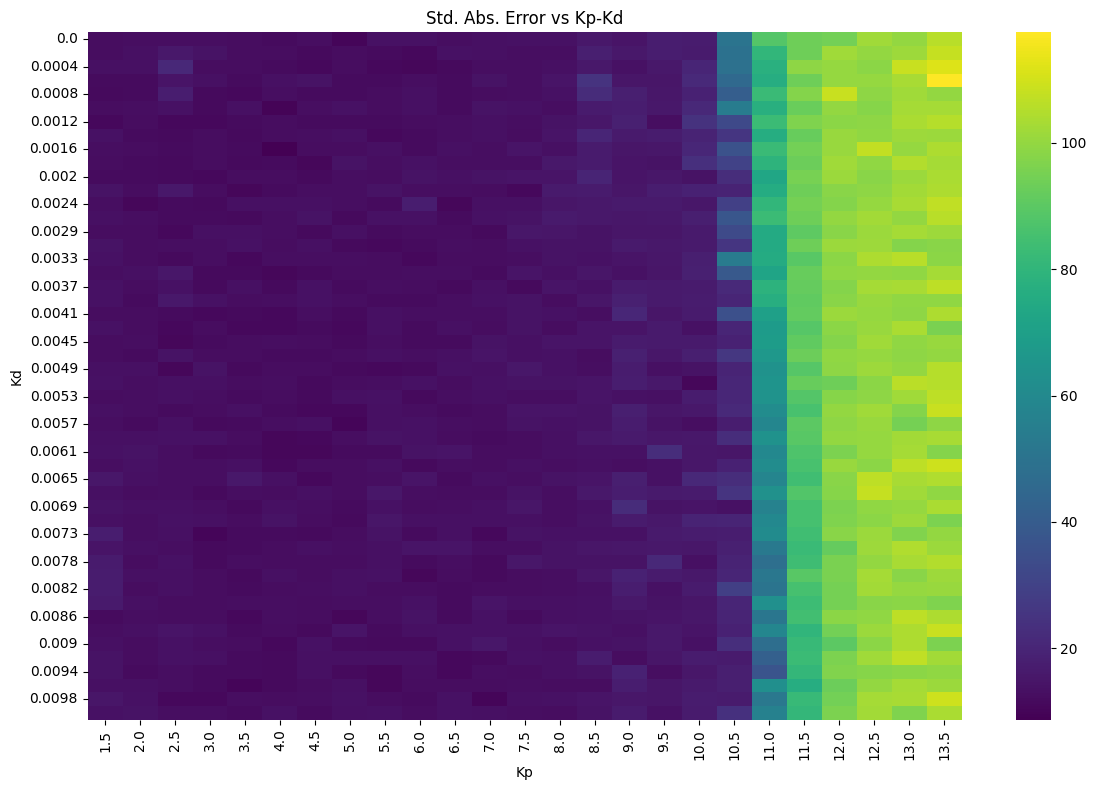

In [40]:
def get_last_100_steps(group):
    return group.tail(100)

last_100_steps = first_exp.groupby(['kp', 'kd']).apply(get_last_100_steps).reset_index(drop=True)

first_exp_grouped = last_100_steps.groupby(['kp', 'kd']).agg({
    'process_variable': ['mean', 'std', 'min', 'max'],
    'control_output': ['mean', 'std', 'min', 'max'],
    'error': ['mean', 'std'],
    'error_abs': ['mean', 'std'],
    'step': 'count',
})

first_exp_grouped.columns = ['pv_mean', 'pv_std', 'pv_min', 'pv_max', 
                            'co_mean', 'co_std', 'co_min', 'co_max', 
                            'error_mean', 'error_std', 'error_abs_mean', 'error_abs_std', 
                            'count']
first_exp_grouped = first_exp_grouped.reset_index()

pivot_std = first_exp_grouped.pivot(index='kd', columns='kp', values='error_abs_std')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_std, cmap='viridis')
plt.title('Std. Abs. Error vs Kp-Kd')
plt.xlabel('Kp')
plt.ylabel('Kd')
plt.tight_layout()
plt.show()

## Анализ второго эксперимента (сканирование только Kp)


C:\Users\artem\AppData\Local\Temp\ipykernel_6088\2141208935.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_100_steps = second_exp.groupby(['kp', 'kd']).apply(get_last_100_steps).reset_index(drop=True)


Статистика по значениям Kp во втором эксперименте:
       kp  pv_mean     pv_std  pv_min  pv_max  co_mean    co_std  co_min  \
0  1.5000   1448.3  24.946610  1380.0  1500.0  1962.46  3.764319  1955.0   
1  1.6212   1507.7  24.114835  1450.0  1570.0  1949.92  3.754270  1941.0   
2  1.7424   1543.1  20.483795  1500.0  1580.0  1940.04  3.498687  1933.0   
3  1.8636   1558.2  19.765289  1510.0  1610.0  1932.74  3.680744  1923.0   
4  1.9848   1566.1  18.904064  1530.0  1610.0  1926.98  3.533333  1920.0   
5  2.1061   1567.3  19.840526  1520.0  1620.0  1922.31  4.536485  1911.0   
6  2.2273   1564.8  20.074608  1510.0  1610.0  1918.21  4.913998  1908.0   
7  2.3485   1563.5  20.907444  1520.0  1610.0  1914.21  4.870640  1903.0   
8  2.4697   1560.2  18.145317  1520.0  1600.0  1910.73  4.713734  1903.0   
9  2.5909   1556.9  20.777562  1510.0  1600.0  1907.36  5.435610  1896.0   

   co_max  error_mean  error_std  error_abs_mean  error_abs_std  count  
0  1973.0       248.3  24.946610       

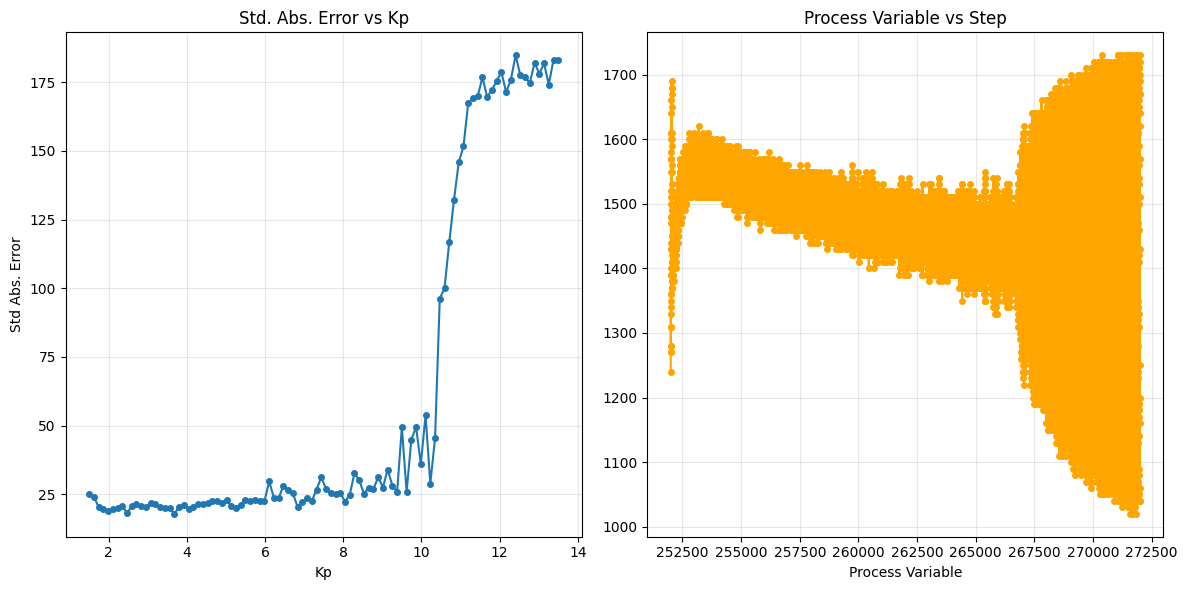

In [35]:
last_100_steps = second_exp.groupby(['kp', 'kd']).apply(get_last_100_steps).reset_index(drop=True)

second_exp_grouped = last_100_steps.groupby('kp').agg({
    'process_variable': ['mean', 'std', 'min', 'max'],
    'control_output': ['mean', 'std', 'min', 'max'],
    'error': ['mean', 'std'],
    'error_abs': ['mean', 'std'],
    'step': 'count',
})

second_exp_grouped.columns = ['pv_mean', 'pv_std', 'pv_min', 'pv_max', 
                            'co_mean', 'co_std', 'co_min', 'co_max', 
                            'error_mean', 'error_std', 'error_abs_mean', 'error_abs_std', 
                            'count']
second_exp_grouped = second_exp_grouped.reset_index()

print(f"Статистика по значениям Kp во втором эксперименте:")
print(second_exp_grouped.head(10))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(second_exp_grouped['kp'], second_exp_grouped['error_abs_std'], 'o-', markersize=4)
plt.title('Std. Abs. Error vs Kp')
plt.xlabel('Kp')
plt.ylabel('Std Abs. Error')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(second_exp['step'], second_exp['process_variable'], 'o-', markersize=4, color='orange')
plt.title('Process Variable vs Step')
plt.xlabel('Step')
plt.xlabel('Process Variable')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
